# Predicción de cáncer de pulmón
Notebook que realiza EDA, preprocesamiento, entrenamiento de modelos, ajuste de hiperparámetros y selección del mejor modelo.

In [40]:
# Librerías
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import joblib
import json
# Ignorar warnings 
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Configuración de rutas y directorios
DATA_PATH = 'data/survey_lung_cancer.csv'
OUTPUT_MODEL = 'models/best_pipeline.joblib'
REPORTS_DIR = 'reports'

os.makedirs('models', exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

In [42]:
# 1) Cargar dataset
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().replace(' ','_') for c in df.columns]
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [43]:
# 2) Transformar target
if df['LUNG_CANCER'].dtype == object:
    df['LUNG_CANCER'] = df['LUNG_CANCER'].str.strip().str.upper().map({'YES':1,'NO':0})
    if df['LUNG_CANCER'].isnull().any():
        print('Valores no mapeados:', df['LUNG_CANCER'].unique())

## 3) Exploración de datos (EDA)

In [44]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
GENDER,309,2,M,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,309.0,NaN,NaN,NaN,62.673139,8.210301,21.0,57.0,62.0,69.0,87.0
SMOKING,309.0,NaN,NaN,NaN,1.563107,0.496806,1.0,1.0,2.0,2.0,2.0
YELLOW_FINGERS,309.0,NaN,NaN,NaN,1.569579,0.495938,1.0,1.0,2.0,2.0,2.0
ANXIETY,309.0,NaN,NaN,NaN,1.498382,0.500808,1.0,1.0,1.0,2.0,2.0
PEER_PRESSURE,309.0,NaN,NaN,NaN,1.501618,0.500808,1.0,1.0,2.0,2.0,2.0
CHRONIC_DISEASE,309.0,NaN,NaN,NaN,1.504854,0.500787,1.0,1.0,2.0,2.0,2.0
FATIGUE,309.0,NaN,NaN,NaN,1.673139,0.469827,1.0,1.0,2.0,2.0,2.0
ALLERGY,309.0,NaN,NaN,NaN,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0
WHEEZING,309.0,NaN,NaN,NaN,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0


In [45]:
df.isnull().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC_DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL_CONSUMING        0
COUGHING                 0
SHORTNESS_OF_BREATH      0
SWALLOWING_DIFFICULTY    0
CHEST_PAIN               0
LUNG_CANCER              0
dtype: int64

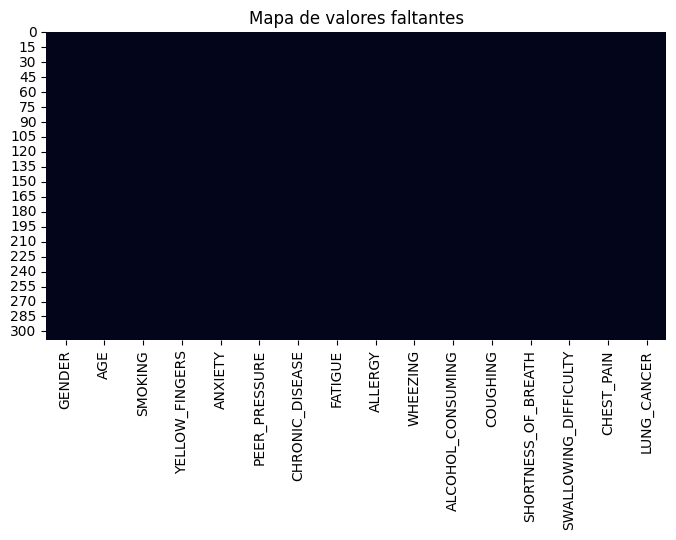

In [46]:
plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Mapa de valores faltantes')
plt.show()

### Valores faltantes
- Numéricas: se rellena con mediana (robusto a outliers).
- Categóricas: se rellena con la categoría más frecuente.

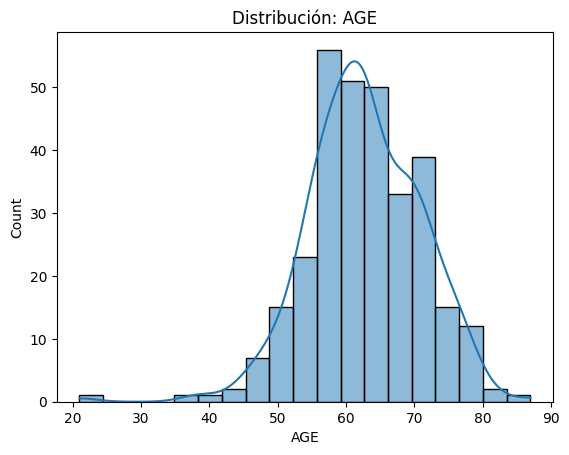

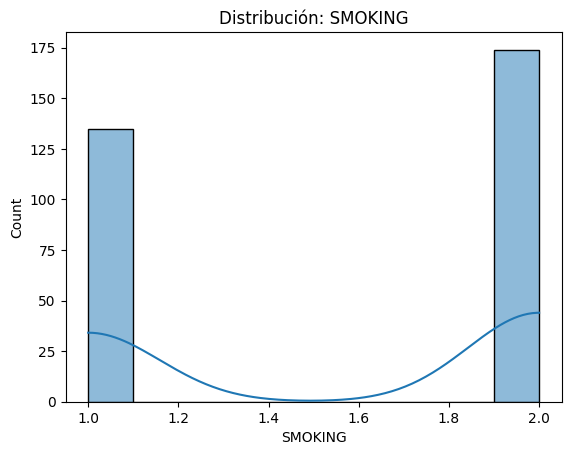

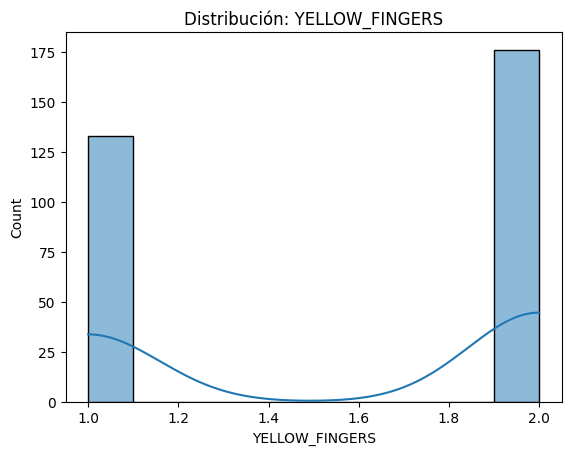

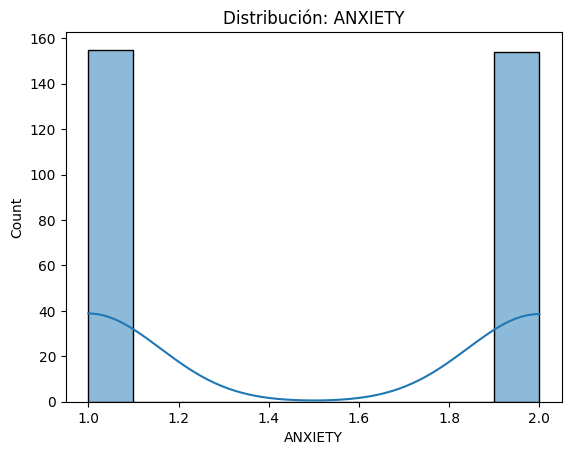

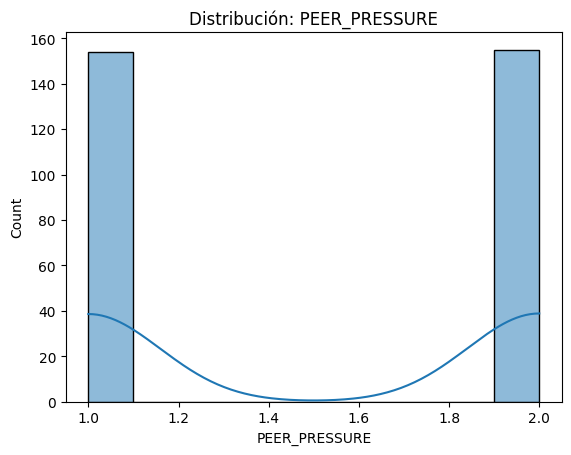

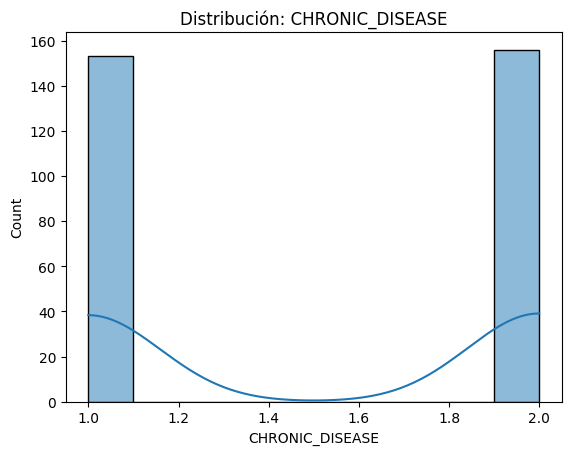

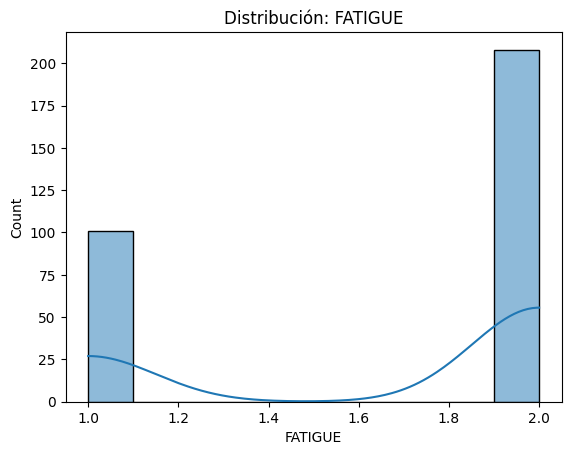

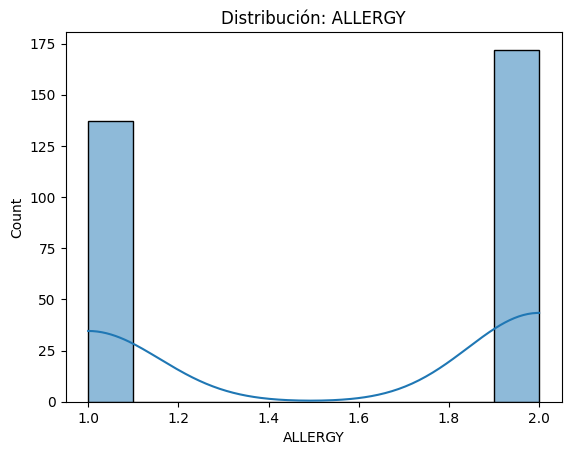

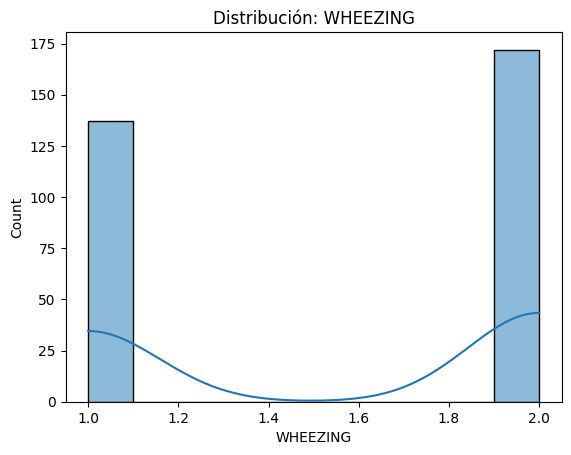

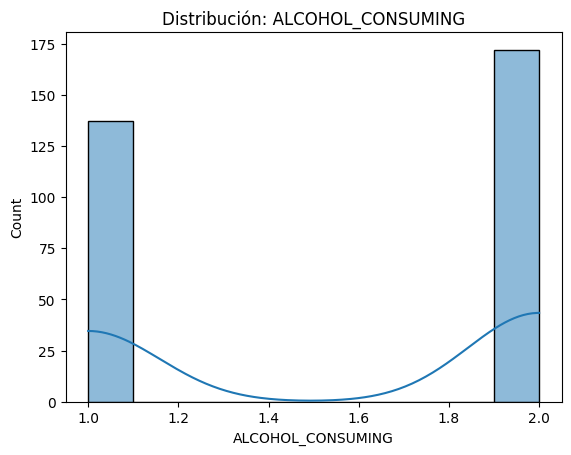

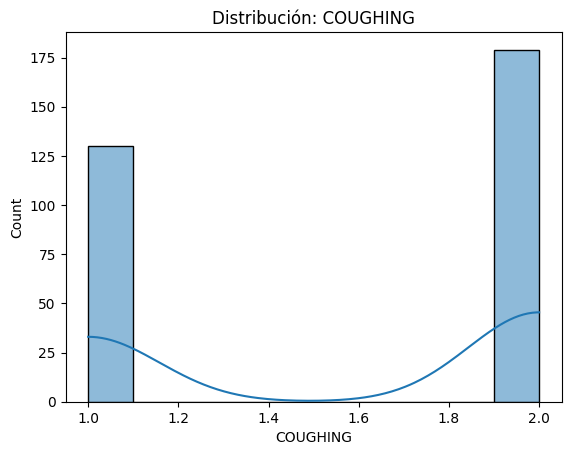

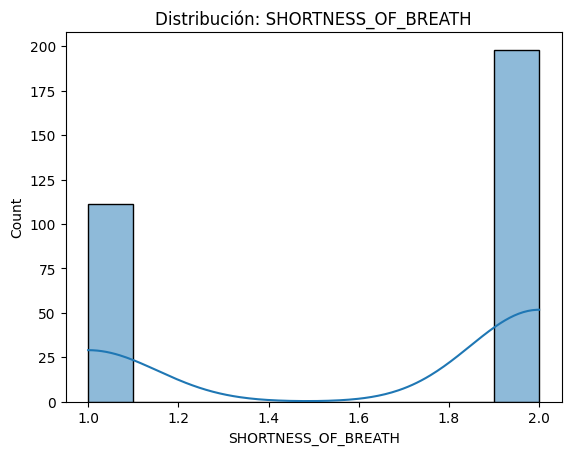

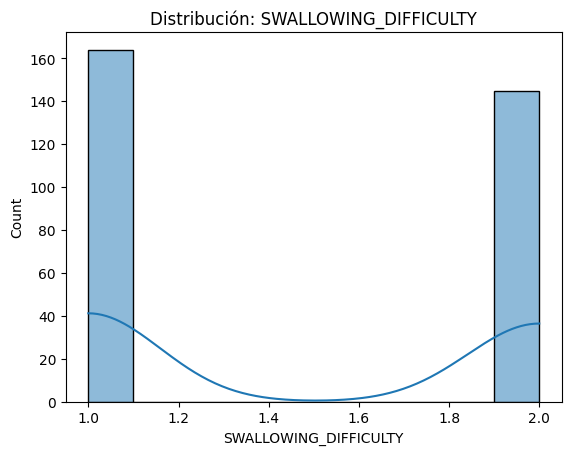

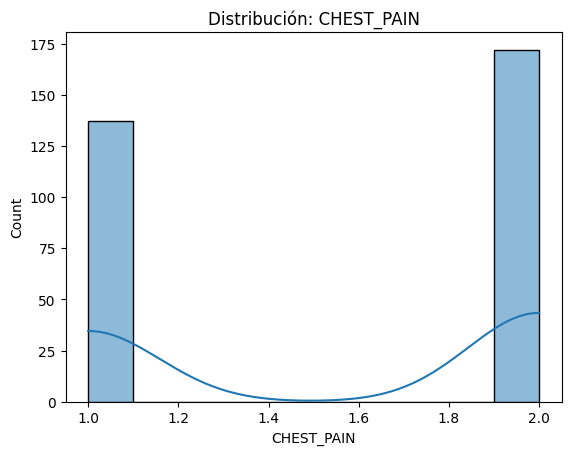

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'LUNG_CANCER' in num_cols: num_cols.remove('LUNG_CANCER')
#para cada columna num crea histogramas
for col in num_cols:
    plt.figure()
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribución: {col}')
    plt.show()

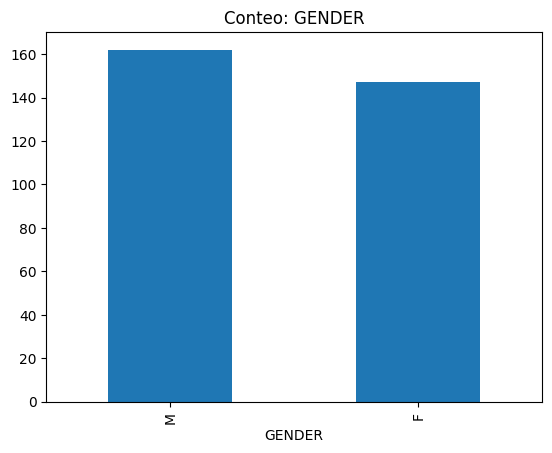

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
# para cada columna cat crea graficos de barras
for col in cat_cols:
    df[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Conteo: {col}')
    plt.show()

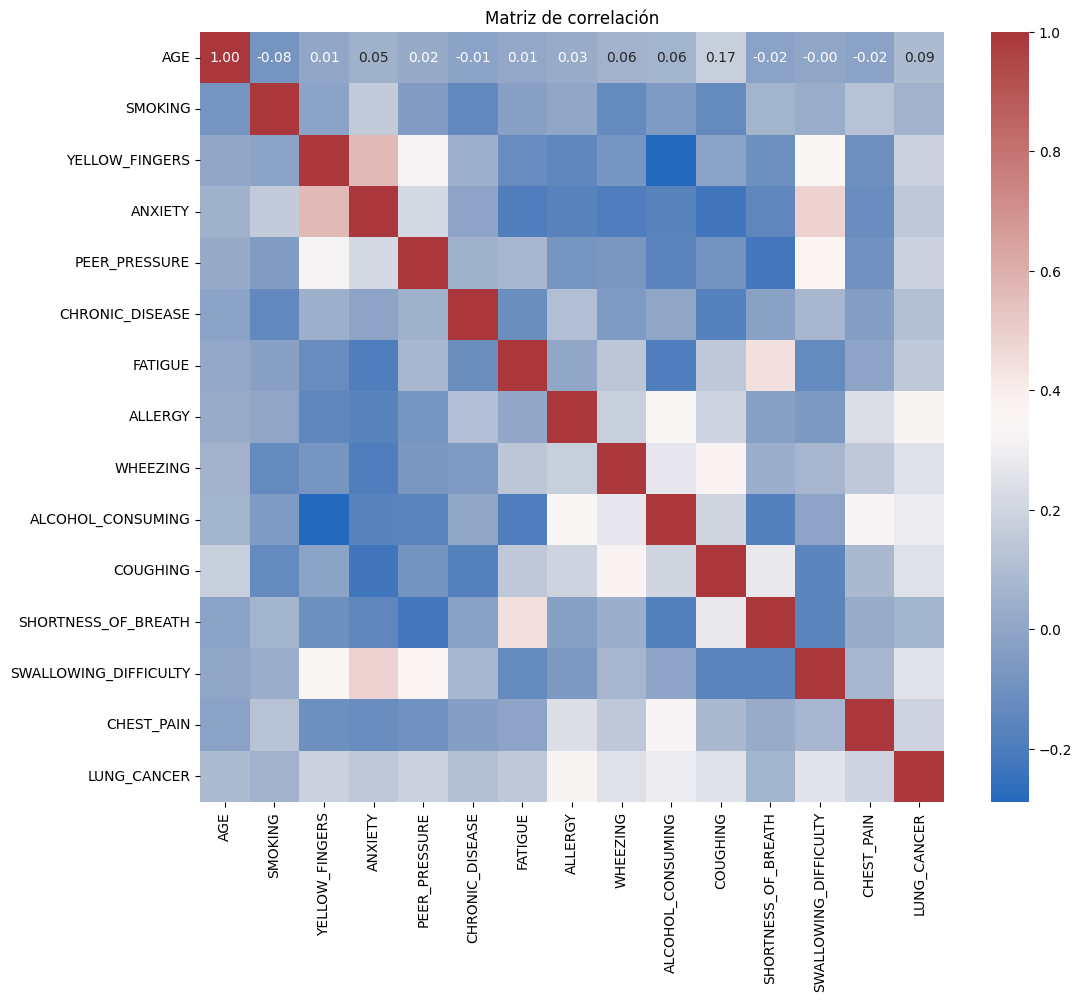

In [ ]:
# Matriz de correlación
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Matriz de correlación')
plt.show()

## 4) Preparación de features y target

In [ ]:
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

for c in categorical_features:
    if X[c].dropna().apply(lambda v: str(v).isdigit()).all():
        X[c] = pd.to_numeric(X[c])

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_features, categorical_features

### Escalado y codificación
- Se usa StandardScaler para variables numéricas (media 0, desviación 1).
- Se usa One Hot Encoding para variables categóricas para evitar que el modelo interprete un orden.

In [51]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
])


### Manejo de valores faltantes

En este proyecto se utiliza **SimpleImputer** para imputar valores faltantes.  
- Para **variables numéricas**, se utiliza la **mediana** como estrategia. Esto se eligió porque la mediana es menos sensible a valores atípicos que la media, lo que ayuda a no distorsionar la distribución de los datos.  
- Para **variables categóricas**, se utiliza el **modo (valor más frecuente)**. Esto permite reemplazar los valores faltantes con la categoría más común, manteniendo la coherencia de la información.

### Escalado de características numéricas

Se utiliza **StandardScaler** para estandarizar las variables numéricas: se transforma cada columna para que tenga **media 0 y desviación estándar 1**.  
- Esto es importante para algoritmos que dependen de la magnitud de los datos, como **KNN** y **Regresión Logística**, ya que evita que las variables con valores más grandes dominen el entrenamiento.  
- Random Forest no requiere escalado estrictamente, pero se mantiene consistente para todos los modelos en el pipeline.


### Codificación de características categóricas

Se aplica **One Hot Encoding** para convertir variables categóricas en representaciones numéricas.  
- Cada categoría se convierte en una columna binaria (0 o 1), evitando que el modelo interprete un orden numérico que no existe.  
- Esto es especialmente útil para modelos como **Logistic Regression**, que requieren datos numéricos y no pueden trabajar con texto directamente.


## 5) Entrenamiento de modelos

In [52]:
models = {
    'logreg': LogisticRegression(max_iter=1000),
    'knn': KNeighborsClassifier(),
    'rf': RandomForestClassifier(random_state=42)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
results = {}

for name, estimator in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', estimator)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
    results[name] = {
        'pipeline': pipe,
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(name, 'F1:', results[name]['f1'])

logreg F1: 0.9444444444444444
knn F1: 0.9357798165137615
rf F1: 0.9345794392523364


### Al ejecutar train.py se evaluan los modelos y dentro mismo se realiza la seleccion de cual modelo es el mejor y se termina guardando como archivo .joblib
